# Reproduction of Spielman et al's "Evaluating social vulnerability indicators"

### Authors

- Liam Smith\*, lwsmith@middlebury.edu, @Liam-W-Smith, ORCID link, Middlebury College
- Joseph Holler, josephh@middlebury.edu , @josephholler, ORCID link, Middlebury College

\* Corresponding author and creator

Version 1.1 | Created 2023-07-12 | Last Updated 2023-07-12  

### Abstract

This study is a *reproduction* of:

> Spielman, S. E., Tuccillo, J., Folch, D. C., Schweikert, A., Davies, R., Wood, N., & Tate, E. (2020). Evaluating Social Vulnerability Indicators: Criteria and their Application to the Social Vulnerability Index. Natural Hazards, 100(1), 417–436. https://doi.org/10.1007/s11069-019-03820-z

The original paper develops methods to evaluate the validity of social vulnerability indicators and applies them to SoVI, revealing issues with internal consistency and construct validity.
Their paper implements these methods by calculating SoVI over various spatial extents in the USA.
In this study, we reproduce Spielman et al's analysis in order to assess the validity of their work.

ADD STUFF: Brief description of the research project, including information about the question, study region(s), method(s), and main result(s).

### Keywords

Social vulnerability, social indicators, Principal Component Analysis, reproducibility

## Study design

We computationally reproduce Spielman et al's original work using the code provided in [their Github repository](https://github.com/geoss/sovi-validity), adapting their code to work in an updated Python environment using current package versions.

Research questions for original paper:
1. What methods can we use to assess the validity of indices used to measure latent variables like SoVI?
2. Is SoVI internally and theoretically consistent?

Research questions for our reproduction:
1. To what extent is Spielman et al's paper reproducible?
2. How can we enhance the paper's reproducibility?

Disclaimer: we worked with the data and code before writing this report, so there is no pre-registration of the analysis plan.
We originally intended to publish only a replication of this study; we did not anticipate publishing a reproduction until we spent some time working with the code.

#### Spatio-temporal metadata

- `Spatial Coverage`: United States, excluding Puerto Rico
- `Spatial Resolution`: Counties and county equivalents
- `Spatial Reference System`: EPSG:4269
- `Temporal Coverage`: 2008 - 2012 (data is the 2012 5-year ACS)
- `Temporal Resolution`: One-time measurement, does not address change over time

## Materials and procedure

### Computational environment

Currently, we are using a 2020 MacBook Pro running on macOS Ventura 13.3.1.
We anticipate collaborators working on the project from different computers and different operating systems, and we seek to containerize the project so that scripts can be run on many different machines.

The original study used Python for their analysis, so we reproduce their results in Python, using a containerized conda environment to be provided in the project's GitHub repository.
This environment consists of the following software and packages:

- Python 3.9.16
- Pandas 1.4.4
- GeoPandas 0.13.2
- Pyhere 1.0.0
- SciPy 1.10.1
- NumPy 1.21.5
- MDP 3.5
- Pygris 0.1.5
- Libpysal 4.7.0
- Lxml 4.9.3
- Tabulate 0.9.0
- Matplotlib 3.7.1

In [1]:
# Import modules, define directories
import pygris
import pandas as pd
import geopandas as gpd
from pygris.utils import shift_geometry
from pygris.data import get_census
from pygris import counties
from pyhere import here
import numpy as np
import libpysal as lps
import lxml
import tabulate
from scipy.stats import spearmanr
from scipy.stats.mstats import zscore as ZSCORE
from scipy.stats import rankdata
import mdp as MDP
from operator import itemgetter
import copy
from matplotlib.colors import ListedColormap    
import matplotlib.pyplot as plt
from IPython import display
from IPython.display import Markdown, Latex

pd.set_option("chained_assignment", None)

path = {
    "dscr": here("data", "scratch"),
    "drpub": here("data", "raw", "public", "spielman", "input"),
    "drpriv": here("data", "raw", "private"),
    "ddpub": here("data", "derived", "public", "version1"),
    "ddpriv": here("data", "derived", "private"),
    "rfig": here("results", "figures"),
    "roth": here("results", "other"),
    "rtab": here("results", "tables")
}

### Data and variables

For Spielman et al's original study, the data sources were the 2008-2012 5-year American Community Survey and the 2010 decennial census.
Spielman et al downloaded their data from Social Explorer; in our reproduction, we pull our data directly from the census into Python via a census API package known as pygris.
These variables are based on the original work by Cutter et al to create SoVI, and cover a wide range of social and demographic information, the particulars of which are described below.

In order to confirm that our data and Spielman et al's data perfectly match each other, we import both datasets here.

In [2]:
# Record raw variable names for Spielman et al's data and our own
acs_variables = [
    "B01002_001E", # median age
    "B03002_001E", # total population of respondents to race/ethnicity
    "B03002_004E", # total black
    "B03002_005E", # total native american
    "B03002_006E", # total asian
    "B03002_012E", # total latinx
    "B06001_002E", # total under 5
    "B09020_001E", # total above 65 
    "B01003_001E", # total population 
    "B25008_001E", # total population in occupied housing units
    "B25002_002E", # total occupied housing units 
    "B25003_003E", # total renter occupied housing units
    "B25002_001E", # total housing units for which occupancy status is known
    "B09020_021E", # total 65+ living in group quarters
    "B01001_026E", # total female
    "B11001_006E", # total female-headed family households
    "B11001_001E", # total households 
    "B25002_003E", # total vacant housing units
    "B19025_001E", # aggregate household income    
    "B23022_025E", # total male unemployed for last 12 months
    "B23022_049E", # total female unemployed for last 12 months
    "B23022_001E", # total for unemployment by sex stats
    "B17021_002E", # total pop below poverty level
    "B17021_001E", # total pop for which poverty info available 
    "B25024_010E", # number of mobile home housing units in structure
    "B25024_001E", # total units in structure
    "C24010_038E", # total female employed
    "C24010_001E", # total for which sex and occupation known
    "B19055_002E", # total households with social security income
    "B19055_001E", # total households for which social security income status known 
    "B09002_002E", # total children in married couple families
    "B09002_001E", # total children by family type and age
    "B19001_017E", # total households over 200k income
    "B06007_005E", # total speak spanish, speak english less than very well
    "B06007_008E", # total speak another language, speak english less than very well
    "B06007_001E", # total speak another language 
    "B16010_002E", # total less than high school
    "B16010_001E", # total for which education, employment, language at home known 
    "C24050_002E", # total in extractive industries
    "C24050_001E", # total for which industry known 
    "C24050_029E", # total in service occupations
    "B08201_002E", # total households no vehicle available
    "B08201_001E", # total households for which vehicle status and family size known 
    "B25064_001E", # median gross rent
    "B25077_001E"  # median home value
]
    
spielman_acs_variables = [
    "ACS12_5yr_B01002001", # median age
    "ACS12_5yr_B03002001", # total population of respondents to race/ethnicity
    "ACS12_5yr_B03002004", # total black
    "ACS12_5yr_B03002005", # total native american
    "ACS12_5yr_B03002006", # total asian
    "ACS12_5yr_B03002012", # total latinx
    "ACS12_5yr_B06001002", # total under 5 
    "ACS12_5yr_B09020001", # total above 65 
    "ACS12_5yr_B01003001", # total population 
    "ACS12_5yr_B25008001", # total population in occupied housing units
    "ACS12_5yr_B25002002", # total occupied housing units
    "ACS12_5yr_B25003003", # total renter occupied housing units
    "ACS12_5yr_B25002001", # total housing units for which occupancy status is known
    "ACS12_5yr_B09020021", # total 65+ living in group quarters
    "ACS12_5yr_B01001026", # total female
    "ACS12_5yr_B11001006", # total female-headed family households
    "ACS12_5yr_B11001001", # total households 
    "ACS12_5yr_B25002003", # total vacant housing units
    "ACS12_5yr_B19025001", # aggregate household income
    "ACS12_5yr_B23022025", # total male unemployed for last 12 months
    "ACS12_5yr_B23022049", # total female unemployed for last 12 months
    "ACS12_5yr_B23022001", # total for unemployment by sex stats
    "ACS12_5yr_B17021002", # total pop below poverty level
    "ACS12_5yr_B17021001", # total pop for which poverty info available 
    "ACS12_5yr_B25024010", # number of mobile home housing units in structure
    "ACS12_5yr_B25024001", # total units in structure
    "ACS12_5yr_C24010038", # total female employed
    "ACS12_5yr_C24010001", # total for which sex and occupation known
    "ACS12_5yr_B19055002", # total households with social security income
    "ACS12_5yr_B19055001", # total households for which social security income status known
    "ACS12_5yr_B09002002", # total children in married couple families
    "ACS12_5yr_B09002001", # total children by family type and age
    "ACS12_5yr_B19001017", # total households over 200k income
    "ACS12_5yr_B06007005", # total speak spanish, speak english less than very well
    "ACS12_5yr_B06007008", # total speak another language, speak english less than very well
    "ACS12_5yr_B06007001", # total speak another language 
    "ACS12_5yr_B16010002", # total less than high school
    "ACS12_5yr_B16010001", # total for which education, employment, language at home known 
    "ACS12_5yr_C24050002", # total in extractive industries
    "ACS12_5yr_C24050001", # total for which industry known 
    "ACS12_5yr_C24050029", # total in service occupations
    "ACS12_5yr_B08201002", # total households no vehicle available
    "ACS12_5yr_B08201001", # total households for which vehicle status and family size known
    "ACS12_5yr_B25064001", # median gross rent
    "ACS12_5yr_B25077001", # median home value
]

#### (1) 2008-2012 American Community Survey (5-year) -- used in both original study and reproduction


In [3]:
# Acquire attribute data for reproduction 
counties_detailed = get_census(dataset = "acs/acs5", # dataset name on the Census API you are connecting to; find datasets at https://api.census.gov/data.html
                        variables = acs_variables, # string (or list of strings) of desired vars. For the 2021 5-year ACS Data Profile, those variable IDs are found at https://api.census.gov/data/2021/acs/acs5/profile/variables.html
                        year = 2012, # year of your data (or end-year for a 5-year ACS sample)
                        params = { # dict of query parameters to send to the API.
                          "for": "county:*"},
                        guess_dtypes = True,
                        return_geoid = True)

# Drop Puerto Rico
counties_detailed = counties_detailed.loc[~counties_detailed['GEOID'].str.startswith('72')]

In [4]:
# Import original data from Spielman et al

# Import base ACS data
make_strings = {'Geo_FIPS': object, 'Geo_STATE': object, 'Geo_COUNTY': object,
                'Geo_TRACT': object, 'Geo_CBSA': object, 'Geo_CSA': object}

acs = pd.read_csv(here(path["drpub"], 'sovi_acs.csv'),
                  dtype=make_strings, skiprows=1,encoding='latin-1')

# Import, join an ACS supplemental
acs_sup2 = pd.read_csv(here(path["drpub"], 'sovi_acs_kids.csv'),
                           dtype=make_strings, skiprows=1,encoding='latin-1')

acs = acs.merge(acs_sup2, how = "inner", on='Geo_FIPS')

# Drop Puerto Rico
acs = acs[acs.Geo_STATE_x != '72'] 

In [5]:
# Document metadata
var_list = pd.read_html("http://api.census.gov/data/2012/acs/acs5/variables.html")[0]

# Convert list to DataFrame
acs_meta = pd.DataFrame( {"Name": acs_variables} )

# Create spielman labels
acs_meta["Spielman Label"] = spielman_acs_variables

# Manually create alias column
acs_meta["Alias"] = ["median age",
                          "total population of respondents to race/ethnicity",
                          "total Black population",
                          "total Native American population",
                          "total Asian population",
                          "total Latinx population",
                          "total population under 5 years of age",
                          "total population over 65 years of age",
                          "total population",
                          "total population in occupied housing units",
                          "total occupied housing units",
                          "total renter occupied housing units",
                          "total housing units for which occupancy status is known",
                          "total 65+ living in group quarters",
                          "total female population",
                          "total female-headed family households",
                          "total households for which household type is known",
                          "total vacant housing units",
                          "aggregate household income",
                          "total males unemployed for last 12 months",
                          "total females unemployed for last 12 months",
                          "total population for which unemployment and sex cross-tabulations known",
                          "total population below poverty level",
                          "total population for which poverty information available",
                          "number of mobile home housing units in structure",
                          "total housing units in structure",
                          "total female employed",
                          "total population for which sex and occupation known",
                          "total households with social security income",
                          "total households for which social security income status known",
                          "total children in married couple families",
                          "total children for which family type and age are known",
                          "total households with over 200k income",
                          "total Spanish-speakers who speak english less than very well",
                          "total people who speak another language and speak English less than very well",
                          "total population with known language spoken at home and English ability",
                          "total population with less than a high school graduate education",
                          "total for which education, employment, language at home known",
                          "total population in extractive industries",
                          "total population for which industry known",
                          "total people in service occupations",
                          "total households with no available vehicle",
                          "total households for which vehicle status and family size known",
                          "median gross rent",
                          "median home value"]
       
# Join metadata from census website
acs_meta = acs_meta.merge(var_list, on = "Name")[["Name", "Spielman Label", "Label", "Concept", "Alias"]]

# Merge information from two columns into one
acs_meta["Definition"] = acs_meta["Concept"] + ": " + acs_meta["Label"]
acs_meta = acs_meta.drop( ["Concept", "Label"], axis = 1 )

# Create data type column
acs_meta["Type"] = np.NaN

for i in range(len(acs_meta)):
    name = acs_meta["Name"][i]
    acs_meta["Type"][i] = counties_detailed[name].dtype
    
# Rename name to label
acs_meta = acs_meta.rename(columns={"Name": "Reproduction Label"})

# Create domain column
acs_meta["Domain"] = np.NaN

for i in range(len(acs_variables)):
    var = acs_meta["Reproduction Label"][i]
    
    var_min = counties_detailed[var].min()
    var_max = counties_detailed[var].max()
    
    if var_min%1 == 0:
        var_min = round(var_min)
    if var_max%1 == 0:
        var_max = round(var_max)
        
    acs_meta["Domain"][i] = str(var_min) + " - " + str(var_max)

# Create missing data column
acs_meta["Missing Data Value(s)"] = np.NaN

# Create missing data frequency
acs_meta["Missing Data Frequency"] = np.NaN

for i in range(len(acs_variables)):
    var = acs_meta["Reproduction Label"][i]
    
    acs_meta["Missing Data Frequency"][i] = np.isnan(counties_detailed[var]).sum()

**Standard Metadata**

- `Abstract`: The 5-year ACS provides estimates surrounding demographic information in the USA. These estimates are more reliable than 1-year and 3-year estimates but less reliable than decennial census data. On the other hand, 5-year estimates are less current than 1-year and 3-year estimates because they represent measurements taken over 60 months. See the [census website](https://www.census.gov/programs-surveys/acs/guidance/estimates.html) for more details.
- `Spatial Coverage`: United States, excluding Puerto Rico
- `Spatial Resolution`: County and county-equivalents
- `Spatial Reference System`: None, just attribute data
- `Temporal Coverage`: 2008-2012
- `Temporal Resolution`: One-time observations
- `Lineage`: Original data downloaded from Social Explorer and then placed in the [original study's GitHub repository](https://github.com/geoss/sovi-validity). Reproduction data obtained directly from the census via API.
- `Distribution`: The reproduction data is distributed via a census API. See the detailed tables on the [census website](https://www.census.gov/data/developers/data-sets/acs-5year/2012.html) and instructions for drawing census data directly into python on the [pygris website](https://walker-data.com/pygris/). Spielman et al originally accessed the ACS data with Social Explorer from the following two tables.
  - http://www.socialexplorer.com/pub/reportdata/HtmlResults.aspx?reportid=R10728365
  - http://www.socialexplorer.com/pub/reportdata/HtmlResults.aspx?reportid=R10775556
- `Constraints`: Census data is available in the public domain
- `Data Quality`: Margin of error provided by the Census Bureau for relevant variables
- `Variables`:  

In [6]:
display.display(Markdown("".join([acs_meta.to_markdown(index = False),'\n| GEOID | Geo_FIPS | FIPS code unique identifier | Unique code for every county and county-equivalent in USA | string | 01001 - 56045 | None | 0 |'])))

| Reproduction Label   | Spielman Label      | Alias                                                                         | Definition                                                                                                                                                                                                                         | Type    | Domain                 |   Missing Data Value(s) |   Missing Data Frequency |
|:---------------------|:--------------------|:------------------------------------------------------------------------------|:-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|:--------|:-----------------------|------------------------:|-------------------------:|
| B01002_001E          | ACS12_5yr_B01002001 | median age                                                                    | MEDIAN AGE BY SEX: Estimate!!Median age!!Total                                                                                                                                                                                     | float64 | 21.7 - 63              |                     nan |                        0 |
| B03002_001E          | ACS12_5yr_B03002001 | total population of respondents to race/ethnicity                             | HISPANIC OR LATINO ORIGIN BY RACE: Estimate!!Total                                                                                                                                                                                 | int64   | 66 - 9840024           |                     nan |                        0 |
| B03002_004E          | ACS12_5yr_B03002004 | total Black population                                                        | HISPANIC OR LATINO ORIGIN BY RACE: Estimate!!Total!!Not Hispanic or Latino!!Black or African American alone                                                                                                                        | int64   | 0 - 1267825            |                     nan |                        0 |
| B03002_005E          | ACS12_5yr_B03002005 | total Native American population                                              | HISPANIC OR LATINO ORIGIN BY RACE: Estimate!!Total!!Not Hispanic or Latino!!American Indian and Alaska Native alone                                                                                                                | int64   | 0 - 59060              |                     nan |                        0 |
| B03002_006E          | ACS12_5yr_B03002006 | total Asian population                                                        | HISPANIC OR LATINO ORIGIN BY RACE: Estimate!!Total!!Not Hispanic or Latino!!Asian alone                                                                                                                                            | int64   | 0 - 1343920            |                     nan |                        0 |
| B03002_012E          | ACS12_5yr_B03002012 | total Latinx population                                                       | HISPANIC OR LATINO ORIGIN BY RACE: Estimate!!Total!!Hispanic or Latino                                                                                                                                                             | int64   | 0 - 4694846            |                     nan |                        0 |
| B06001_002E          | ACS12_5yr_B06001002 | total population under 5 years of age                                         | PLACE OF BIRTH BY AGE IN THE UNITED STATES: Estimate!!Total!!Under 5 years                                                                                                                                                         | float64 | 0 - 651662             |                     nan |                        0 |
| B09020_001E          | ACS12_5yr_B09020001 | total population over 65 years of age                                         | RELATIONSHIP BY HOUSEHOLD TYPE (INCLUDING LIVING ALONE) FOR THE POPULATION 65 YEARS AND OVER: Estimate!!Total                                                                                                                      | int64   | 5 - 1078555            |                     nan |                        0 |
| B01003_001E          | ACS12_5yr_B01003001 | total population                                                              | TOTAL POPULATION: Estimate!!Total                                                                                                                                                                                                  | int64   | 66 - 9840024           |                     nan |                        0 |
| B25008_001E          | ACS12_5yr_B25008001 | total population in occupied housing units                                    | TOTAL POPULATION IN OCCUPIED HOUSING UNITS BY TENURE: Estimate!!Total                                                                                                                                                              | int64   | 62 - 9664175           |                     nan |                        0 |
| B25002_002E          | ACS12_5yr_B25002002 | total occupied housing units                                                  | OCCUPANCY STATUS: Estimate!!Total!!Occupied                                                                                                                                                                                        | int64   | 35 - 3218511           |                     nan |                        0 |
| B25003_003E          | ACS12_5yr_B25003003 | total renter occupied housing units                                           | TENURE: Estimate!!Total!!Renter occupied                                                                                                                                                                                           | int64   | 14 - 1695180           |                     nan |                        0 |
| B25002_001E          | ACS12_5yr_B25002001 | total housing units for which occupancy status is known                       | OCCUPANCY STATUS: Estimate!!Total                                                                                                                                                                                                  | int64   | 70 - 3441416           |                     nan |                        0 |
| B09020_021E          | ACS12_5yr_B09020021 | total 65+ living in group quarters                                            | RELATIONSHIP BY HOUSEHOLD TYPE (INCLUDING LIVING ALONE) FOR THE POPULATION 65 YEARS AND OVER: Estimate!!Total!!In group quarters                                                                                                   | int64   | 0 - 37611              |                     nan |                        0 |
| B01001_026E          | ACS12_5yr_B01001026 | total female population                                                       | SEX BY AGE: Estimate!!Total!!Female                                                                                                                                                                                                | int64   | 20 - 4987765           |                     nan |                        0 |
| B11001_006E          | ACS12_5yr_B11001006 | total female-headed family households                                         | HOUSEHOLD TYPE (INCLUDING LIVING ALONE): Estimate!!Total!!Family households!!Other family!!Female householder, no husband present                                                                                                  | int64   | 0 - 498851             |                     nan |                        0 |
| B11001_001E          | ACS12_5yr_B11001001 | total households for which household type is known                            | HOUSEHOLD TYPE (INCLUDING LIVING ALONE): Estimate!!Total                                                                                                                                                                           | int64   | 35 - 3218511           |                     nan |                        0 |
| B25002_003E          | ACS12_5yr_B25002003 | total vacant housing units                                                    | OCCUPANCY STATUS: Estimate!!Total!!Vacant                                                                                                                                                                                          | int64   | 35 - 245069            |                     nan |                        0 |
| B19025_001E          | ACS12_5yr_B19025001 | aggregate household income                                                    | AGGREGATE HOUSEHOLD INCOME IN THE PAST 12 MONTHS (IN 2012 INFLATION-ADJUSTED DOLLARS): Estimate!!Aggregate household income in the past 12 months (in 2012 inflation-adjusted dollars)                                             | int64   | 1785600 - 263044380000 |                     nan |                        0 |
| B23022_025E          | ACS12_5yr_B23022025 | total males unemployed for last 12 months                                     | SEX BY WORK STATUS IN THE PAST 12 MONTHS BY USUAL HOURS WORKED PER WEEK IN THE PAST 12 MONTHS BY WEEKS WORKED IN THE PAST 12 MONTHS FOR THE POPULATION 16 TO 64 YEARS: Estimate!!Total!!Male!!Did not work in the past 12 months   | int64   | 1 - 726803             |                     nan |                        0 |
| B23022_049E          | ACS12_5yr_B23022049 | total females unemployed for last 12 months                                   | SEX BY WORK STATUS IN THE PAST 12 MONTHS BY USUAL HOURS WORKED PER WEEK IN THE PAST 12 MONTHS BY WEEKS WORKED IN THE PAST 12 MONTHS FOR THE POPULATION 16 TO 64 YEARS: Estimate!!Total!!Female!!Did not work in the past 12 months | int64   | 0 - 1131737            |                     nan |                        0 |
| B23022_001E          | ACS12_5yr_B23022001 | total population for which unemployment and sex cross-tabulations known       | SEX BY WORK STATUS IN THE PAST 12 MONTHS BY USUAL HOURS WORKED PER WEEK IN THE PAST 12 MONTHS BY WEEKS WORKED IN THE PAST 12 MONTHS FOR THE POPULATION 16 TO 64 YEARS: Estimate!!Total                                             | int64   | 45 - 6658456           |                     nan |                        0 |
| B17021_002E          | ACS12_5yr_B17021002 | total population below poverty level                                          | POVERTY STATUS OF INDIVIDUALS IN THE PAST 12 MONTHS BY LIVING ARRANGEMENT: Estimate!!Total!!Income in the past 12 months below poverty level                                                                                       | int64   | 0 - 1658231            |                     nan |                        0 |
| B17021_001E          | ACS12_5yr_B17021001 | total population for which poverty information available                      | POVERTY STATUS OF INDIVIDUALS IN THE PAST 12 MONTHS BY LIVING ARRANGEMENT: Estimate!!Total                                                                                                                                         | int64   | 64 - 9684503           |                     nan |                        0 |
| B25024_010E          | ACS12_5yr_B25024010 | number of mobile home housing units in structure                              | UNITS IN STRUCTURE: Estimate!!Total!!Mobile home                                                                                                                                                                                   | int64   | 0 - 85377              |                     nan |                        0 |
| B25024_001E          | ACS12_5yr_B25024001 | total housing units in structure                                              | UNITS IN STRUCTURE: Estimate!!Total                                                                                                                                                                                                | int64   | 70 - 3441416           |                     nan |                        0 |
| C24010_038E          | ACS12_5yr_C24010038 | total female employed                                                         | SEX BY OCCUPATION FOR THE CIVILIAN EMPLOYED POPULATION 16 YEARS AND OVER: Estimate!!Total!!Female                                                                                                                                  | int64   | 12 - 2056023           |                     nan |                        0 |
| C24010_001E          | ACS12_5yr_C24010001 | total population for which sex and occupation known                           | SEX BY OCCUPATION FOR THE CIVILIAN EMPLOYED POPULATION 16 YEARS AND OVER: Estimate!!Total                                                                                                                                          | int64   | 54 - 4495118           |                     nan |                        0 |
| B19055_002E          | ACS12_5yr_B19055002 | total households with social security income                                  | SOCIAL SECURITY INCOME IN THE PAST 12 MONTHS FOR HOUSEHOLDS: Estimate!!Total!!With Social Security income                                                                                                                          | int64   | 9 - 726298             |                     nan |                        0 |
| B19055_001E          | ACS12_5yr_B19055001 | total households for which social security income status known                | SOCIAL SECURITY INCOME IN THE PAST 12 MONTHS FOR HOUSEHOLDS: Estimate!!Total                                                                                                                                                       | int64   | 35 - 3218511           |                     nan |                        0 |
| B09002_002E          | ACS12_5yr_B09002002 | total children in married couple families                                     | OWN CHILDREN UNDER 18 YEARS BY FAMILY TYPE AND AGE: Estimate!!Total!!In married-couple families                                                                                                                                    | int64   | 0 - 1380977            |                     nan |                        0 |
| B09002_001E          | ACS12_5yr_B09002001 | total children for which family type and age are known                        | OWN CHILDREN UNDER 18 YEARS BY FAMILY TYPE AND AGE: Estimate!!Total                                                                                                                                                                | int64   | 0 - 2032147            |                     nan |                        0 |
| B19001_017E          | ACS12_5yr_B19001017 | total households with over 200k income                                        | HOUSEHOLD INCOME IN THE PAST 12 MONTHS (IN 2012 INFLATION-ADJUSTED DOLLARS): Estimate!!Total!!$200,000 or more                                                                                                                     | int64   | 0 - 208954             |                     nan |                        0 |
| B06007_005E          | ACS12_5yr_B06007005 | total Spanish-speakers who speak english less than very well                  | PLACE OF BIRTH BY LANGUAGE SPOKEN AT HOME AND ABILITY TO SPEAK ENGLISH IN THE UNITED STATES: Estimate!!Total!!Speak Spanish!!Speak English less than "very well"                                                                   | float64 | 0 - 1695391            |                     nan |                        0 |
| B06007_008E          | ACS12_5yr_B06007008 | total people who speak another language and speak English less than very well | PLACE OF BIRTH BY LANGUAGE SPOKEN AT HOME AND ABILITY TO SPEAK ENGLISH IN THE UNITED STATES: Estimate!!Total!!Speak other languages!!Speak English less than "very well"                                                           | float64 | 0 - 743418             |                     nan |                        0 |
| B06007_001E          | ACS12_5yr_B06007001 | total population with known language spoken at home and English ability       | PLACE OF BIRTH BY LANGUAGE SPOKEN AT HOME AND ABILITY TO SPEAK ENGLISH IN THE UNITED STATES: Estimate!!Total                                                                                                                       | float64 | 66 - 9188362           |                     nan |                        0 |
| B16010_002E          | ACS12_5yr_B16010002 | total population with less than a high school graduate education              | EDUCATIONAL ATTAINMENT AND EMPLOYMENT STATUS BY LANGUAGE SPOKEN AT HOME FOR THE POPULATION 25 YEARS AND OVER: Estimate!!Total!!Less than high school graduate                                                                      | int64   | 5 - 1508273            |                     nan |                        0 |
| B16010_001E          | ACS12_5yr_B16010001 | total for which education, employment, language at home known                 | EDUCATIONAL ATTAINMENT AND EMPLOYMENT STATUS BY LANGUAGE SPOKEN AT HOME FOR THE POPULATION 25 YEARS AND OVER: Estimate!!Total                                                                                                      | int64   | 65 - 6380366           |                     nan |                        0 |
| C24050_002E          | ACS12_5yr_C24050002 | total population in extractive industries                                     | INDUSTRY BY OCCUPATION FOR THE CIVILIAN EMPLOYED POPULATION 16 YEARS AND OVER: Estimate!!Total!!Agriculture, forestry, fishing and hunting, and mining                                                                             | int64   | 0 - 54942              |                     nan |                        0 |
| C24050_001E          | ACS12_5yr_C24050001 | total population for which industry known                                     | INDUSTRY BY OCCUPATION FOR THE CIVILIAN EMPLOYED POPULATION 16 YEARS AND OVER: Estimate!!Total                                                                                                                                     | int64   | 54 - 4495118           |                     nan |                        0 |
| C24050_029E          | ACS12_5yr_C24050029 | total people in service occupations                                           | INDUSTRY BY OCCUPATION FOR THE CIVILIAN EMPLOYED POPULATION 16 YEARS AND OVER: Estimate!!Total!!Service occupations                                                                                                                | int64   | 4 - 837607             |                     nan |                        0 |
| B08201_002E          | ACS12_5yr_B08201002 | total households with no available vehicle                                    | HOUSEHOLD SIZE BY VEHICLES AVAILABLE: Estimate!!Total!!No vehicle available                                                                                                                                                        | int64   | 0 - 577967             |                     nan |                        0 |
| B08201_001E          | ACS12_5yr_B08201001 | total households for which vehicle status and family size known               | HOUSEHOLD SIZE BY VEHICLES AVAILABLE: Estimate!!Total                                                                                                                                                                              | int64   | 35 - 3218511           |                     nan |                        0 |
| B25064_001E          | ACS12_5yr_B25064001 | median gross rent                                                             | MEDIAN GROSS RENT (DOLLARS): Estimate!!Median gross rent                                                                                                                                                                           | int64   | 296 - 1678             |                     nan |                        0 |
| B25077_001E          | ACS12_5yr_B25077001 | median home value                                                             | MEDIAN VALUE (DOLLARS): Estimate!!Median value (dollars)                                                                                                                                                                           | float64 | 19400 - 944100         |                     nan |                        1 |
| GEOID | Geo_FIPS | FIPS code unique identifier | Unique code for every county and county-equivalent in USA | string | 01001 - 56045 | None | 0 |

#### (2) 2010 Decennial Census -- used in Spielman et al's original study

In [7]:
# Import decennial supplemental
dec_sup1 = pd.read_csv(here(path["drpub"],'sovi_decennial_sup1.csv'),
        dtype=make_strings,skiprows=1,encoding='latin-1')

**Standard Metadata**

- `Abstract`: Collected once every ten years, the decennial census documents demographic and population data in the United States.
- `Spatial Coverage`: United States, excluding Puerto Rico
- `Spatial Resolution`: County and county-equivalents
- `Spatial Reference System`: None, just attribute data
- `Temporal Coverage`: 2010
- `Temporal Resolution`: One-time observations
- `Lineage`: Original data downloaded from Social Explorer and then placed in the [original study's GitHub repository](https://github.com/geoss/sovi-validity).
- `Distribution`: Visit [this URL](http://www.socialexplorer.com/pub/reportdata/HtmlResults.aspx?reportid=R10728369) for access
- `Constraints`: Census data is available in the public domain
- `Data Quality`: Margin of error provided by the Census Bureau for relevant variables
- `Variables`:

| Label | Alias | Definition | Type | Accuracy | Domain | Missing Data Value(s) | Missing Data Frequency |
| :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: |
| SE_T02A_002 | Land area | Area (Land) in square miles | float64 |  ... | 1.998779 - 145504.8 | nan | 0 |
| Geo_FIPS | FIPS code unique identifier | Unique code for every county and county-equivalent in USA | string | ... | g01001 - g56045 | None | 0 |


#### (3) USA Counties Shapefile -- used in Spielman et al's original study

In [8]:
spielman_geom = gpd.read_file( here(path["drpub"], "USA_Counties_500k.shp") )

**Standard Metadata**

- `Abstract`: No metadata provided, so it is unclear exactly where Spielman et al acquired this file but they likely downloaded it directly or indirectly from the census. The shapefile provides the geometries of counties and county-equivalents in the United States, with limited attribute information including county name and a unique identifier.
- `Spatial Coverage`: United States, excluding Puerto Rico
- `Spatial Resolution`: County and county-equivalents
- `Spatial Reference System`: EPSG:4269
- `Temporal Coverage`: Unknown
- `Temporal Resolution`: One-time observations
- `Lineage`: Unknown
- `Distribution`: Unknown. Presumably downloaded from census.
- `Constraints`: Census data is available in the public domain
- `Data Quality`: (ADD))
- `Variables`: For each variable, enter the following information. If you have two or more variables per data source, you may want to present this information in table form (shown below)

| Label | Alias | Definition | Type | Accuracy | Domain | Missing Data Value(s) | Missing Data Frequency |
| :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: |
| geoFIPS | FIPS code unique identifer | Unique code for every county and county-equivalent in USA | string | ... | g01001 - g56045 | None | 0 |


#### (4) USA Counties Cartographic Boundaries -- used in replication study



In [9]:
# Acquire geographical data for reproduction
counties_shp = counties(cb = True, year = 2010, cache = True) # year 2012 (and 2011) cartographic boundaries not available

**Standard Metadata**

- `Abstract`: The cartographic boundary files provided by the US census are simplified representations of the MAF/TIGER files. We use the 2010 boundary file because the census has not made such a file available for 2012 or 2011 and the original paper also used land area from 2010. This shapefile provides the geometries of counties and county-equivalents in the United States, with limited attribute information including land area.
- `Spatial Coverage`: United States, excluding Puerto Rico
- `Spatial Resolution`: County and county-equivalents
- `Spatial Reference System`: EPSG:4269
- `Temporal Coverage`: Specify the temporal extent of your study---i.e. the range of time represented by the data observations.
- `Temporal Resolution`: One-time observations
- `Lineage`: We use [pygris](https://walker-data.com/pygris/) to pull the data directly from the census into python.
- `Distribution`: This file is distributed via a census API. See more information on the [census website](https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.2010.html#list-tab-1556094155) and instructions for drawing census data directly into python on the [pygris website](https://walker-data.com/pygris/).
- `Constraints`: Census data is available in the public domain
- `Data Quality`: (ADD))
- `Variables`: For each variable, enter the following information. If you have two or more variables per data source, you may want to present this information in table form (shown below)

| Label | Alias | Definition | Type | Accuracy | Domain | Missing Data Value(s) | Missing Data Frequency |
| :--: | :--: | :--: | :--: | :--: | :--: | :--: | :--: |
| STATE | State-level FIPS code | State-level FIPS code | string | ... | 01 - 56 | None | 0 |
| COUNTY | County-level FIPS code | County-level FIPS code | string | ... | 001 - 840 | None | 0 |
| CENSUSAREA | land area | land area in square miles | float64 | ... | 1.999 - 145504.789 | nan | 0 |

### Data transformations
A workflow diagram for this section is displayed below.

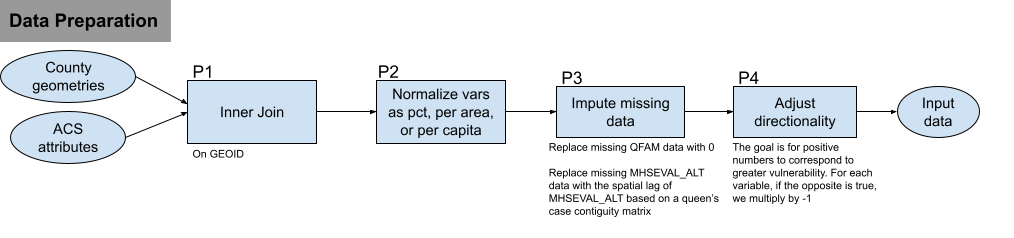

In [10]:
display.Image(here(path["rfig"], "workflow_data_transformations.png"))

We begin with step P1: joining the geometry and attribute data

In [11]:
# Step P1
# Join geometry and attribute data for reproduction 
counties_shp['GEOID'] = counties_shp.STATE + counties_shp.COUNTY
counties = counties_shp.merge(counties_detailed, how = "inner", on = "GEOID")

# Also join Spielman's land area information to the rest of Spielman's data
# (to check that all data is accurate, not for purposes of analysis)
acs = acs.merge(dec_sup1, how = "inner", on='Geo_FIPS')

Before normalizing variables for input into SoVI, we verify that the data we drew directly from the census into python matches Spielman et al's data. To begin, we define a function that can check that the entries of two pandas DataFrames are equal.

In [12]:
# Define a function that can determine whether every entry in specified columns of two tables match  
def equiv(table1, sort1, column1, table2, sort2, column2):
    ''' 
    Tests two tables to see whether corresponding columns have equivalent entries.
    
    Parameters:
    table1 - the first table
    sort1 - the column in the first table to join by (str)
    column1 - the column(s) in the first table to test the values of (list of str) (should list analogous columns for columns2) 
    table2 - the second table
    sort2 - the column in the second table to join by (str)
    column2 - the column(s) in the second table to test the values of (list of str)
    '''
    # Sort tables
    table1 = table1.sort_values(by = sort1).reset_index()
    table2 = table2.sort_values(by = sort2).reset_index()
    
    # Rename column name in table2 to match that in table1
    for i in range(len(column1)):
        table2 = table2.rename(columns={column2[i]: column1[i]})

    # Select the columns to test equivalency of
    table1 = table1[column1]
    table2 = table2[column1]
    
    # Perform equivalency test
    test = table1.eq(table2)
    return test

Next, we round our area columns to the nearest integer. These columns came from different sources and we know that they do not match up exactly.

In [13]:
# Round area column
acs['SE_T02A_002_check'] = acs.SE_T02A_002.round(0)
counties['CENSUSAREA_check'] = counties.CENSUSAREA.round(0)

# Add the area variables to the lists of variables
acs_variables.append('CENSUSAREA_check')
spielman_acs_variables.append('SE_T02A_002_check')

In [14]:
# Perform equivalency test
test = equiv(counties, "GEOID", acs_variables, acs, "Geo_FIPS", spielman_acs_variables)
matching_cols = pd.DataFrame({"test": test.sum().eq(3143)}) # 3143 matches the number of rows (3221 if PR included)
matching_cols.loc[~matching_cols.test] # Identify the columns that have some data discrepencies

,test
B25077_001E,False
CENSUSAREA_check,False


The following variables have some discrepancy between the original and reproduction data:
- B25077_001E
- CENSUSAREA

In [15]:
# Inspect the data values at the indices with data discrepancies

# Find the rows for which there are data discrepancies
messed_up_indices = test[["CENSUSAREA_check", "B25077_001E"]].loc[~test.CENSUSAREA_check |~test.B25077_001E]

# Select the data of interest from tygris
tygris_data = counties.sort_values(by = "GEOID")\
    .reset_index().loc[messed_up_indices.index]\
    [["GEOID", "CENSUSAREA", "CENSUSAREA_check", "B25077_001E"]]

# Select the data of interest from Spielman et al
spielman_data = acs.sort_values(by = "Geo_FIPS")\
    .reset_index().loc[messed_up_indices.index]\
    [["Geo_FIPS", "SE_T02A_002", "SE_T02A_002_check", "ACS12_5yr_B25077001"]]

# Join and inspect
merged = tygris_data.merge(spielman_data, how = "inner", left_on = "GEOID", right_on = "Geo_FIPS")
merged

,GEOID,CENSUSAREA,CENSUSAREA_check,B25077_001E,Geo_FIPS,SE_T02A_002,SE_T02A_002_check,ACS12_5yr_B25077001
0,13171,183.500,184.0,119800.0,13171,183.49990,183.0,119800.0
1,15005,11.991,12.0,NaN,15005,11.99148,12.0,NaN
2,17157,575.500,576.0,89300.0,17157,575.49980,575.0,89300.0
3,39089,682.500,682.0,151300.0,39089,682.50010,683.0,151300.0


By inspection, we see that the one disagreement between B25077_001E and ACS12_5yr_B25077001 occurs because of a NaN value in an analogous location in each of the two datasets.

We also see that in the 3 cases where we have a disagreement between CENSUSAREA and SE_T02A_002, the two values differ only by 1 (this variable was rounded to the 1's place). This minor discrepancy is unlikely to influence our results.

Our data sufficiently matches Spielman et al's. Also, this shows us that we will need to impute a missing value for one NaN in B25077_001E -- median home value (see P3).

In [16]:
# Step P2
# Calculating the variables used in SoVI
counties['MEDAGE_ACS'] = counties.B01002_001E
counties['BLACK_ACS'] = counties.B03002_004E / (counties.B03002_001E)
counties['QNATAM_ACS'] = counties.B03002_005E / (counties.B03002_001E)
counties['QASIAN_ACS'] = counties.B03002_006E / (counties.B03002_001E)
counties['QHISP_ACS'] = counties.B03002_012E / (counties.B03002_001E)
counties['QAGEDEP_ACS'] = (counties.B06001_002E + counties.B09020_001E) / (counties.B01003_001E)
counties['QPUNIT_ACS'] = counties.B25008_001E / (counties.B25002_002E)
counties['PRENTER_ACS'] = counties.B25003_003E / (counties.B25002_001E)
counties['QNRRES_ACS'] = counties.B09020_021E / (counties.B01003_001E)
counties['QFEMALE_ACS'] = counties.B01001_026E / (counties.B01003_001E)
counties['QFHH_ACS'] = counties.B11001_006E / (counties.B11001_001E)
counties['QUNOCCHU_ACS'] = counties.B25002_003E / (counties.B25002_001E)
counties['QCVLUN'] = (counties.B23022_025E + counties.B23022_049E) / \
                counties.B23022_001E
counties['QPOVTY'] = (counties.B17021_002E) / counties.B17021_001E
counties['QMOHO'] = (counties.B25024_010E) / counties.B25024_001E
counties['QFEMLBR'] = (counties.C24010_038E) / counties.C24010_001E
counties['QSSBEN'] = (counties.B19055_002E) / counties.B19055_001E
counties['QFAM'] = (counties.B09002_002E) / counties.B09002_001E
counties['QRICH200K'] = (counties.B19001_017E) / counties.B11001_001E # would B19001_001E be a better denominator?
counties['PERCAP_ALT'] = counties.B19025_001E / (counties.B25008_001E) 
counties['QESL_ALT'] = (counties.B06007_005E + counties.B06007_008E) / \
                  counties.B06007_001E
counties['QED12LES_ALT'] = (counties.B16010_002E) / counties.B16010_001E 
counties['QEXTRCT_ALT'] = (counties.C24050_002E) / counties.C24050_001E 
counties['QSERV_ALT'] = (counties.C24050_029E) / counties.C24050_001E 
counties['QNOAUTO_ALT'] = (counties.B08201_002E) / counties.B08201_001E 
counties['MDGRENT_ALT'] = counties.B25064_001E 
counties['MHSEVAL_ALT'] = counties.B25077_001E 
counties['POPDENS'] = counties.B01003_001E / (counties.CENSUSAREA)

As noted before, B25077_001E is missing a data value.
We now perform one final check to see if we need to impute anything else.

In [17]:
# Check for missing data
for i in counties.columns:
    x = counties[i].isnull().sum()
    if x > 0:
        print(i, "contains", x, "missing value(s).")
        
# Check for infinities
counties_num = counties.select_dtypes(include=['int64','float64'])
for i in counties_num.columns:
    xmin = counties_num[i].min()
    xmax = counties_num[i].max()
    if xmin == -np.inf:
        print(i, "contains a negative infinity")
    elif xmax == np.inf:
        print(i, "contains a positive infinity")

LSAD contains 2 missing value(s).
B25077_001E contains 1 missing value(s).
QFAM contains 2 missing value(s).
MHSEVAL_ALT contains 1 missing value(s).


There are four variables with missing data. LSAD is not used in our analysis, so we may ignore this. B25077_001E and MHSEVAL_ALT are literally identical, so we will ignore B25077_001E and simply impute for MHSEVAL_ALT's one missing value. We also need to impute for QFAM's 2 missing values. We use the same imputation decisions that Spielman et al employ in their analysis.

In [18]:
# Step P3
# Replace missing QFAM data with 0
counties.QFAM = counties.QFAM.replace([np.inf, -np.inf, np.nan], 0)

# Replace missing MHSEVAL_ALT data with its spatial lag

# Calculate spatial weights matrix
w = lps.weights.Queen.from_dataframe(counties) 
w.transform = 'R'
# Calculate spatial lag
counties['MHSEVAL_ALT_LAG'] = lps.weights.lag_spatial(w, counties.MHSEVAL_ALT)
# Impute for the missing value
counties.MHSEVAL_ALT[np.isnan(counties['MHSEVAL_ALT'])] = counties[["MHSEVAL_ALT_LAG"]][pd.isna(counties['MHSEVAL_ALT'])]

('WARNING: ', 68, ' is an island (no neighbors)')
('WARNING: ', 546, ' is an island (no neighbors)')
('WARNING: ', 547, ' is an island (no neighbors)')
('WARNING: ', 549, ' is an island (no neighbors)')
('WARNING: ', 1226, ' is an island (no neighbors)')
('WARNING: ', 1876, ' is an island (no neighbors)')
('WARNING: ', 2976, ' is an island (no neighbors)')


/Users/liamsmith/opt/anaconda3/envs/RPl-Spielman-2020/lib/python3.9/site-packages/libpysal/weights/weights.py:172: UserWarning: The weights matrix is not fully connected: 
 There are 10 disconnected components.
 There are 7 islands with ids: 68, 546, 547, 549, 1226, 1876, 2976.
  warnings.warn(message)


Before adjusting directionality, let us check that all of our derived variables match all of Spielman et al's derived variables.

In [19]:
# Import Spielman et al's derived variables
US_All = pd.read_csv(here("data", "raw", "public", "spielman", "output", "sovi_inputs.csv"))
counties.to_csv(here(path["ddpub"],'counties.csv'))  
counties = pd.read_csv(here(path["ddpub"], "counties.csv"), dtype = {'GEOID': object})

In [20]:
# Select only the relevant columns

# Attribute name and expected influence on vulnerability
input_names = [['MEDAGE_ACS', 'pos', 'person', 'Median Age'],
               ['BLACK_ACS', 'pos', 'person', 'Pop African-American (%)'],
               ['QNATAM_ACS', 'pos', 'person', 'Pop Native American (%)'],
               ['QASIAN_ACS', 'pos', 'person', 'Pop Asian (%)'],
               ['QHISP_ACS', 'pos', 'person', 'Pop Hispanic (%)'],
               ['QAGEDEP_ACS', 'pos', 'person', 'Age Dependency (%)'],
               ['QPUNIT_ACS', 'pos', 'person', 'Persons Per Housing Unit'],
               ['PRENTER_ACS', 'pos', 'hu', 'Rental Housing (%)'],
               ['QNRRES_ACS', 'pos', 'person', 'Nursing Home Residents (%)'],
               ['QFEMALE_ACS', 'pos', 'person', 'Pop Female (%)'],
               ['QFHH_ACS', 'pos', 'hu', 'Female-Headed Households (%)'],
               ['QUNOCCHU_ACS', 'pos', 'hu', 'Vacant Housing (%)'],
               ['PERCAP_ALT', 'neg', 'person', 'Per-Capita Income'],
               ['QESL_ALT', 'pos', 'person', 'English as Second Language (%)'],
               ['QCVLUN', 'pos', 'person', 'Unemployment (%)'],
               ['QPOVTY', 'pos', 'person', 'Poverty (%)'],
               ['QMOHO', 'pos', 'hu', 'Mobile Homes (%)'],
               ['QED12LES_ALT', 'pos', 'person',
                   'Adults Completed <Grade 12 (%)'],
               ['QFEMLBR', 'pos', 'person', 'Female Employment (%)'],
               ['QEXTRCT_ALT', 'pos', 'person',
                   'Extractive Sector Employment (%)'],
               ['QSERV_ALT', 'pos', 'person', 'Service Sector Employment (%)'],
               ['QSSBEN', 'pos', 'hu', 'Social Security Income (%)'],
               ['QNOAUTO_ALT', 'pos', 'hu', 'No Automobile (%)'],
               ['QFAM', 'neg', 'person', 'Children in Married Families (%)'],
               ['QRICH200K', 'neg', 'hu', 'Annual Income >$200K (%)'],
               ['MDGRENT_ALT', 'neg', 'hu', 'Median Rent'],
               ['MHSEVAL_ALT', 'neg', 'hu', 'Median Home Value'],
               ['POPDENS', 'pos', 'person', 'Population Density']]

# Get attribute names
attr_names1 = [j[0] for j in input_names] + ['GEOID']
attr_names2 = [j[0] for j in input_names] + ['Geo_FIPS']

# Select only the columns needed to compute SoVI
counties = counties[attr_names1]
US_All = US_All[attr_names2]

counties["GEOID"] = "g" + counties["GEOID"]
counties['stateID'] = counties.GEOID.str.slice(0, 3, 1)
attr_names1.remove('GEOID')
counties = counties.set_index(counties["GEOID"]).sort_index()

US_All['stateID'] = US_All.Geo_FIPS.str.slice(0, 3, 1)
attr_names2.remove('Geo_FIPS')
US_All = US_All.set_index(US_All["Geo_FIPS"]).sort_index()

In [24]:
counties.eq(US_All).sum()

BLACK_ACS       3143
GEOID              0
Geo_FIPS           0
MDGRENT_ALT     3143
MEDAGE_ACS      3143
MHSEVAL_ALT     3143
PERCAP_ALT      3143
POPDENS          853
PRENTER_ACS     3143
QAGEDEP_ACS     3143
QASIAN_ACS      3143
QCVLUN          3143
QED12LES_ALT    3143
QESL_ALT        3143
QEXTRCT_ALT     3143
QFAM            3143
QFEMALE_ACS     3143
QFEMLBR         3143
QFHH_ACS        3143
QHISP_ACS       3143
QMOHO           3143
QNATAM_ACS      3143
QNOAUTO_ALT     3143
QNRRES_ACS      3143
QPOVTY          3143
QPUNIT_ACS      3143
QRICH200K       3143
QSERV_ALT       3143
QSSBEN          3143
QUNOCCHU_ACS    3143
stateID         3143
dtype: int64

In [25]:
popdens = counties[["POPDENS"]].round(0).eq(US_All[["POPDENS"]].round(0))#.sum()
print(popdens.sum()[0], "of 3143 observations agree when rounded to nearest integer. \nThe observations that disagree are printed below. \nAs you can see, the two are basically the same.")
counties.loc[~popdens["POPDENS"]][["POPDENS"]].merge(US_All.loc[~popdens["POPDENS"]][["POPDENS"]], left_index = True, right_index = True)

3136 of 3143 observations agree when rounded to nearest integer. 
The observations that disagree are printed below. 
As you can see, the two are basically the same.


,POPDENS_x,POPDENS_y
GEOID,,
g34013,6210.502963,6210.488201
g36061,69943.273906,69944.223694
g51580,1079.553767,1079.455850
g51610,6153.076538,6153.756869
g51640,842.475728,842.518059
g51685,5686.266772,5686.816602
g51690,1264.512596,1264.481434


Now we proceed to step P4, switching the directionality of variables as needed in order to ensure that higher values of a variable are associated with higher levels of vulnerability.

In [26]:
# Step P4
# Flip signs as needed to ensure that each variable contributes as expected to the final Sovi
for name, sign, sample, hrname in input_names:
    if sign == 'neg':
        counties[name] = -counties[name].values
    elif sign == 'pos':
        pass
    else:
        print("problem in flipping signs")
        raise

### Analysis

Spielman et al constructed a class to conduct SPSS-style PCA with varimax rotation in python. Below is their class definition, which I use to reproduce their analysis later on. INCLUDE WORKFLOW DIAGRAM AS WELL

In [ ]:
class SPSS_PCA:
	'''
	A class that integrates most (all?) of the assumptions SPSS imbeds in their
    implimnetation of principle components analysis (PCA), which can be found in
    thier GUI under Analyze > Dimension Reduction > Factor. This class is not
	intended to be a full blown recreation of the SPSS Factor Analysis GUI, but
	it does replicate (possibly) the most common use cases. Note that this class
	will not produce exactly the same results as SPSS, probably due to differences
	in how eigenvectors/eigenvalues and/or singular values are computed. However,
	this class does seem to get all the signs to match, which is not really necessary
	but kinda nice. Most of the approach came from the official SPSS documentation.

	References
	----------
	ftp://public.dhe.ibm.com/software/analytics/spss/documentation/statistics/20.0/en/client/Manuals/IBM_SPSS_Statistics_Algorithms.pdf
	http://spssx-discussion.1045642.n5.nabble.com/Interpretation-of-PCA-td1074350.html
	http://mdp-toolkit.sourceforge.net/api/mdp.nodes.WhiteningNode-class.html
	https://github.com/mdp-toolkit/mdp-toolkit/blob/master/mdp/nodes/pca_nodes.py

	Parameters
	----------
	inputs:  numpy array
			 n x k numpy array; n observations and k variables on each observation
	reduce:  boolean (default=False)
			 If True, then use eigenvalues to determine which factors to keep; all
			 results will be based on just these factors. If False use all factors.
	min_eig: float (default=1.0)
			 If reduce=True, then keep all factors with an eigenvalue greater than
			 min_eig. SPSS default is 1.0. If reduce=False, then min_eig is ignored.
	varimax: boolean (default=False)
			 If True, then apply a varimax rotation to the results. If False, then
			 return the unrotated results only.

	Attributes
	----------
	z_inputs:	numpy array
				z-scores of the input array.
	comp_mat:	numpy array
				Component matrix (a.k.a, "loadings").
	scores:		numpy array
				New uncorrelated vectors associated with each observation.
	eigenvals_all:	numpy array
				Eigenvalues associated with each factor.
	eigenvals:	numpy array
				Subset of eigenvalues_all reflecting only those that meet the
				criterion defined by parameters reduce and min_eig.
	weights:    numpy array
				Values applied to the input data (after z-scores) to get the PCA
				scores. "Component score coefficient matrix" in SPSS or
				"projection matrix" in the MDP library.
	comms: 		numpy array
				Communalities
	sum_sq_load: numpy array
				 Sum of squared loadings.
	comp_mat_rot: numpy array or None
				  Component matrix after rotation. Ordered from highest to lowest
				  variance explained based on sum_sq_load_rot. None if varimax=False.
	scores_rot:	numpy array or None
				Uncorrelated vectors associated with each observation, after
				rotation. None if varimax=False.
	weights_rot: numpy array or None
				Rotated values applied to the input data (after z-scores) to get
				the PCA	scores. None if varimax=False.
	sum_sq_load_rot: numpy array or None
				 Sum of squared loadings for rotated results. None if
				 varimax=False.

	'''

	def __init__(self, inputs, reduce=False, min_eig=1.0, varimax=False):
		z_inputs = ZSCORE(inputs)  # seems necessary for SPSS "correlation matrix" setting (their default)

		# run base SPSS-style PCA to get all eigenvalues
		pca_node = MDP.nodes.WhiteningNode()  # settings for the PCA
		scores = pca_node.execute(z_inputs)  # base run PCA
		eigenvalues_all = pca_node.d   # rename PCA results

		# run SPSS-style PCA based on user settings
		pca_node = MDP.nodes.WhiteningNode(reduce=reduce, var_abs=min_eig)  # settings for the PCA
		scores = pca_node.execute(z_inputs)  # run PCA  (these have mean=0, std_dev=1)
		weights = pca_node.v  # rename PCA results (these might be a transformation of the eigenvectors)
		eigenvalues = pca_node.d   # rename PCA results
		component_matrix = weights * eigenvalues  # compute the loadings
		component_matrix = self._reflect(component_matrix)   # get signs to match SPSS
		communalities = (component_matrix**2).sum(1)   # compute the communalities
		sum_sq_loadings = (component_matrix**2).sum(0) # note that this is the same as eigenvalues
		weights_reflected = component_matrix/eigenvalues  # get signs to match SPSS
		scores_reflected = np.dot(z_inputs, weights_reflected)  # note that abs(scores)=abs(scores_reflected)

		if varimax:
			# SPSS-style varimax rotation prep
			c_normalizer = 1. / MDP.numx.sqrt(communalities)  # used to normalize inputs to varimax
			c_normalizer.shape = (component_matrix.shape[0],1)  # reshape to vectorize normalization
			cm_normalized = c_normalizer * component_matrix  # normalize component matrix for varimax

			# varimax rotation
			cm_normalized_varimax = self._varimax(cm_normalized)  # run varimax
			c_normalizer2 = MDP.numx.sqrt(communalities)  # used to denormalize varimax output
			c_normalizer2.shape = (component_matrix.shape[0],1)  # reshape to vectorize denormalization
			cm_varimax = c_normalizer2 * cm_normalized_varimax  # denormalize varimax output

			# reorder varimax component matrix
			sorter = (cm_varimax**2).sum(0)  # base the ordering on sum of squared loadings
			sorter = zip(sorter.tolist(), range(sorter.shape[0]))  # add index to denote current order
			sorter = sorted(sorter, key=itemgetter(0), reverse=True)  # sort from largest to smallest
			sum_sq_loadings_varimax, reorderer = zip(*sorter)  # unzip the sorted list
			sum_sq_loadings_varimax = np.array(sum_sq_loadings_varimax)  # convert to array
			cm_varimax = cm_varimax[:,reorderer]  # reorder component matrix

			# varimax scores
			cm_varimax_reflected = self._reflect(cm_varimax)  # get signs to match SPSS
			varimax_weights = np.dot(cm_varimax_reflected,
							  np.linalg.inv(np.dot(cm_varimax_reflected.T,
							  cm_varimax_reflected))) # CM(CM'CM)^-1
			scores_varimax = np.dot(z_inputs, varimax_weights)
		else:
			comp_mat_rot = None
			scores_rot = None
			weights_rot = None

		# assign output variables
		self.z_inputs = z_inputs
		self.scores = scores_reflected
		self.comp_mat = component_matrix
		self.eigenvals_all = eigenvalues_all
		self.eigenvals = eigenvalues
		self.weights = weights_reflected
		self.comms = communalities
		self.sum_sq_load = sum_sq_loadings
		self.comp_mat_rot = cm_varimax_reflected
		self.scores_rot = scores_varimax
		self.weights_rot = varimax_weights
		self.sum_sq_load_rot = sum_sq_loadings_varimax

	def _reflect(self, cm):
		# reflect factors with negative sums; SPSS default
		cm = copy.deepcopy(cm)
		reflector = cm.sum(0)
		for column, measure in enumerate(reflector):
			if measure < 0:
				cm[:,column] = -cm[:,column]
		return cm

	def _varimax(self, Phi, gamma = 1.0, q = 100, tol = 1e-6):
		# downloaded from http://en.wikipedia.org/wiki/Talk%3aVarimax_rotation
		# also here http://stackoverflow.com/questions/17628589/perform-varimax-rotation-in-python-using-numpy
		p,k = Phi.shape
		R = np.eye(k)
		d=0
		for i in range(q):
			d_old = d
			Lambda = np.dot(Phi, R)
			u,s,vh = np.linalg.svd(np.dot(Phi.T,np.asarray(Lambda)**3 - (gamma/p) *
							np.dot(Lambda, np.diag(np.diag(np.dot(Lambda.T,Lambda))))))
			R = np.dot(u,vh)
			d = np.sum(s)
			if d_old!=0 and d/d_old < 1 + tol:
				break
		return np.dot(Phi, R)